<a href="https://colab.research.google.com/github/FatemehRajabi/gold-usd-prediction/blob/main/baseline_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#!pip install yfinance scikit-learn


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Get today's date
today = datetime.date.today()

# Load Gold ETF (GLD) data from Yahoo Finance
data = yf.download('GLD', start='2015-01-01', end=today)

# Flatten MultiIndex
data.columns = data.columns.get_level_values(0)
data.columns.name = None

# Keep only relevant columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,112.489998,114.800003,112.320000,114.080002,7109600
2015-01-05,114.779999,116.000000,114.730003,115.800003,8177400
2015-01-06,116.220001,117.500000,115.800003,117.120003,11238300
2015-01-07,116.470001,116.879997,116.169998,116.430000,6434200
2015-01-08,116.449997,116.870003,115.849998,115.940002,7033700


In [12]:
# Simple Moving Averages
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# Relative Strength Index (RSI)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Drop rows with NaNs from indicators
data.dropna(inplace=True)

data.head()

,Open,High,Low,Close,Volume,SMA_10,SMA_30,RSI_14
Date,,,,,,,,
2015-02-13,118.050003,118.580002,117.790001,117.980003,4108900,119.551000,120.106667,35.742753
2015-02-17,116.400002,116.540001,115.580002,116.010002,7225200,118.910001,120.171001,26.861544
2015-02-18,115.989998,116.529999,114.989998,116.339996,8336000,118.439000,120.189000,29.748256
2015-02-19,116.400002,116.540001,115.739998,115.940002,6528700,117.875000,120.149667,34.165550
2015-02-20,116.099998,116.459999,115.050003,115.279999,6681700,117.224000,120.111334,19.029545


In [13]:
# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print("Scaled shape:", scaled_data.shape)

Scaled shape: (2553, 8)


In [14]:
# Create sequences (60 timesteps back)
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # shape: (60, 8)
    y.append(scaled_data[i, 3])  # predict the Close price (index 3)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 60, 8)
print("y shape:", y.shape)  # (samples,)

X shape: (2493, 60, 8)
y shape: (2493,)


In [15]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test (no shuffling for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [16]:
# pip install pandas matplotlib pmdarima statsmodels scikit-learn


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.0889
MAE: 0.0741


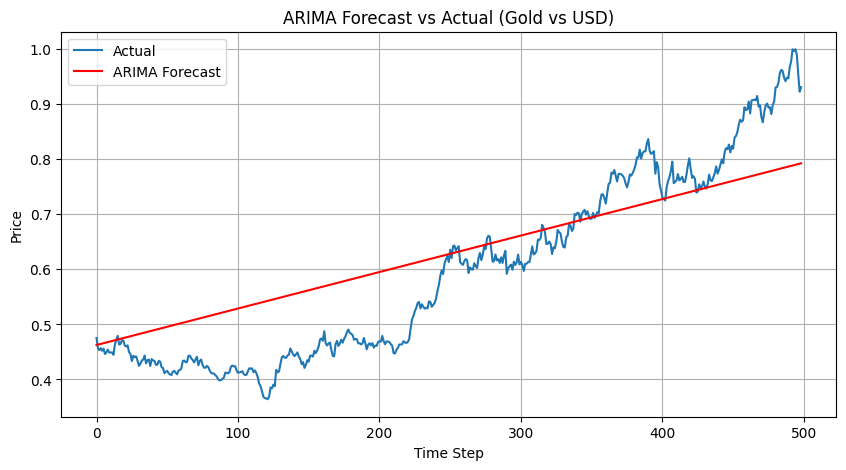

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


# y_train and y_test must be 1D Series or arrays
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Manually set ARIMA(p, d, q) parameters
model = ARIMA(y_train, order=(4,2,2))
model_fit = model.fit()

# Forecast same number of steps as test set
forecast = model_fit.forecast(steps=len(y_test))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, forecast, label='ARIMA Forecast', color='red')
plt.title("ARIMA Forecast vs Actual (Gold vs USD)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


Starting grid search...
Checked ARIMA(0,0,0) → RMSE: 0.4206, MAE: 0.3855


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Checked ARIMA(0,0,1) → RMSE: 0.4205, MAE: 0.3852
Checked ARIMA(0,0,2) → RMSE: 0.4203, MAE: 0.3849


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Checked ARIMA(0,0,3) → RMSE: 0.4202, MAE: 0.3846


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Checked ARIMA(0,0,4) → RMSE: 0.4202, MAE: 0.3845
Checked ARIMA(0,1,0) → RMSE: 0.2166, MAE: 0.1587


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(0,1,1) → RMSE: 0.2165, MAE: 0.1586


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(0,1,2) → RMSE: 0.2168, MAE: 0.1588
Checked ARIMA(0,1,3) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(0,1,4) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(0,2,0) → RMSE: 1.2049, MAE: 1.0760
Checked ARIMA(0,2,1) → RMSE: 0.1386, MAE: 0.1098


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(0,2,2) → RMSE: 0.1385, MAE: 0.1098


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(0,2,3) → RMSE: 0.1347, MAE: 0.1073
Checked ARIMA(0,2,4) → RMSE: 0.1970, MAE: 0.1873
Checked ARIMA(1,0,0) → RMSE: 0.2609, MAE: 0.1925
Checked ARIMA(1,0,1) → RMSE: 0.2630, MAE: 0.1942
Checked ARIMA(1,0,2) → RMSE: 0.2585, MAE: 0.1906
Checked ARIMA(1,0,3) → RMSE: 0.2602, MAE: 0.1919
Checked ARIMA(1,0,4) → RMSE: 0.2618, MAE: 0.1933


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(1,1,0) → RMSE: 0.2164, MAE: 0.1586
Checked ARIMA(1,1,1) → RMSE: 0.2166, MAE: 0.1587
Checked ARIMA(1,1,2) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(1,1,3) → RMSE: 0.2166, MAE: 0.1587
Checked ARIMA(1,1,4) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(1,2,0) → RMSE: 1.3304, MAE: 1.1851
Checked ARIMA(1,2,1) → RMSE: 0.1385, MAE: 0.1098
Checked ARIMA(1,2,2) → RMSE: 0.1465, MAE: 0.1148
Checked ARIMA(1,2,3) → RMSE: 0.4377, MAE: 0.4063
Checked ARIMA(1,2,4) → RMSE: 0.4019, MAE: 0.3746


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Checked ARIMA(2,0,0) → RMSE: 0.2635, MAE: 0.1946
Checked ARIMA(2,0,1) → RMSE: 0.2585, MAE: 0.1907
Checked ARIMA(2,0,2) → RMSE: 0.2596, MAE: 0.1914
Checked ARIMA(2,0,3) → RMSE: 0.2634, MAE: 0.1945


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(2,0,4) → RMSE: 0.2628, MAE: 0.1940
Checked ARIMA(2,1,0) → RMSE: 0.2168, MAE: 0.1588
Checked ARIMA(2,1,1) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(2,1,2) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(2,1,3) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(2,1,4) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(2,2,0) → RMSE: 0.6967, MAE: 0.6334


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(2,2,1) → RMSE: 0.1365, MAE: 0.1084
Checked ARIMA(2,2,2) → RMSE: 0.1126, MAE: 0.0925


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(2,2,3) → RMSE: 0.1259, MAE: 0.1017


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(2,2,4) → RMSE: 0.0897, MAE: 0.0749


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(3,0,0) → RMSE: 0.2571, MAE: 0.1895
Checked ARIMA(3,0,1) → RMSE: 0.2588, MAE: 0.1909
Checked ARIMA(3,0,2) → RMSE: 0.2598, MAE: 0.1917
Checked ARIMA(3,0,3) → RMSE: 0.2640, MAE: 0.1950
Checked ARIMA(3,0,4) → RMSE: 0.2608, MAE: 0.1925
Checked ARIMA(3,1,0) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(3,1,1) → RMSE: 0.2167, MAE: 0.1588


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Checked ARIMA(3,1,2) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(3,1,3) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(3,1,4) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(3,2,0) → RMSE: 0.2590, MAE: 0.2454


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Checked ARIMA(3,2,1) → RMSE: 0.1972, MAE: 0.1874


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(3,2,2) → RMSE: 0.1407, MAE: 0.1110


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(3,2,3) → RMSE: 0.1349, MAE: 0.1075


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(3,2,4) → RMSE: 0.1368, MAE: 0.1087
Checked ARIMA(4,0,0) → RMSE: 0.2590, MAE: 0.1910
Checked ARIMA(4,0,1) → RMSE: 0.2603, MAE: 0.1920


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(4,0,2) → RMSE: 0.3934, MAE: 0.3136


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Checked ARIMA(4,0,3) → RMSE: 0.2185, MAE: 0.1601
Checked ARIMA(4,0,4) → RMSE: 0.2603, MAE: 0.1920
Checked ARIMA(4,1,0) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(4,1,1) → RMSE: 0.2167, MAE: 0.1588


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Checked ARIMA(4,1,2) → RMSE: 0.2167, MAE: 0.1588
Checked ARIMA(4,1,3) → RMSE: 0.2169, MAE: 0.1589


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(4,1,4) → RMSE: 0.2166, MAE: 0.1587
Checked ARIMA(4,2,0) → RMSE: 0.0976, MAE: 0.0838


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(4,2,1) → RMSE: 0.0982, MAE: 0.0844


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(4,2,2) → RMSE: 0.0889, MAE: 0.0741


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Checked ARIMA(4,2,3) → RMSE: 0.1400, MAE: 0.1107
Checked ARIMA(4,2,4) → RMSE: 0.0980, MAE: 0.0813

Best ARIMA order: (4, 2, 2)
Lowest RMSE: 0.0889

Refitting best model...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


De-normalized RMSE: 16.6889
De-normalized MAE: 13.9073


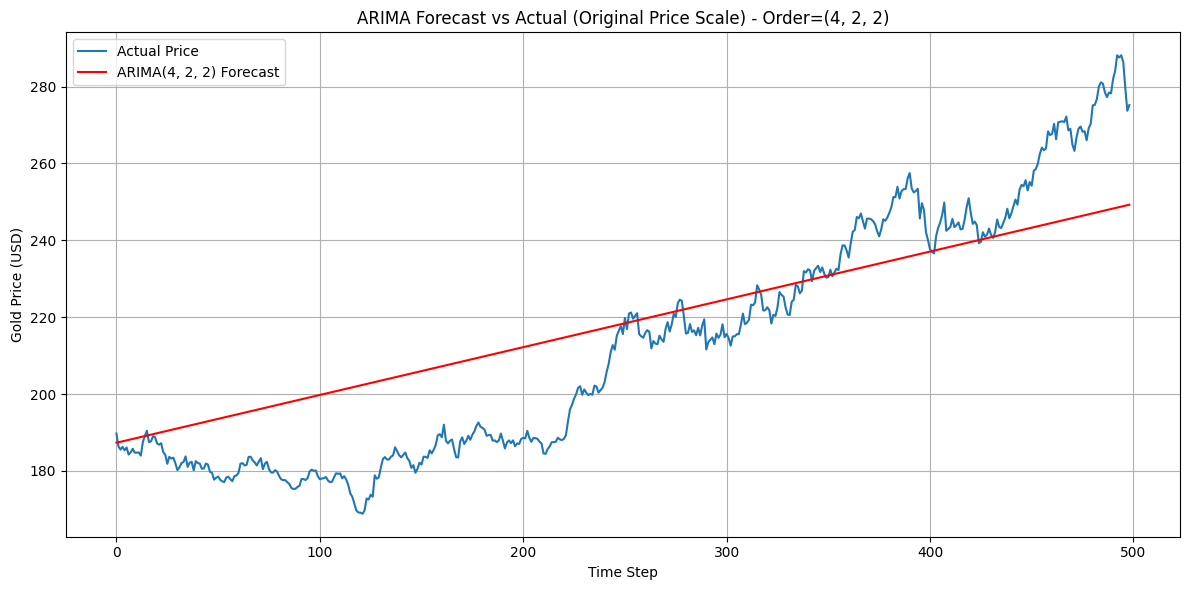

In [18]:
# Grid of p, d, q
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_score = float("inf")
best_params = None
results = []

print("Starting grid search...")

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(y_train, order=(p, d, q))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(y_test))
                rmse = np.sqrt(mean_squared_error(y_test, forecast))
                mae = mean_absolute_error(y_test, forecast)
                results.append(((p, d, q), rmse, mae))

                if rmse < best_score:
                    best_score = rmse
                    best_params = (p, d, q)

                print(f"Checked ARIMA({p},{d},{q}) → RMSE: {rmse:.4f}, MAE: {mae:.4f}")
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) failed: {e}")

print("\nBest ARIMA order:", best_params)
print(f"Lowest RMSE: {best_score:.4f}")

# Step 2: Refit best model
print("\nRefitting best model...")
best_model = ARIMA(y_train, order=best_params)
best_fit = best_model.fit()
forecast = best_fit.forecast(steps=len(y_test))

# Step 3: De-normalize both predictions and actuals
forecast_2d = np.array(forecast).reshape(-1, 1)
y_test_2d = np.array(y_test).reshape(-1, 1)

# Index 3 corresponds to 'Close' in the original data
def inverse_transform_single_column(scaler, data_col, column_index=3):
    dummy = np.zeros((len(data_col), scaler.n_features_in_))
    dummy[:, column_index] = data_col.flatten()
    inverse = scaler.inverse_transform(dummy)
    return inverse[:, column_index]

# De-normalize
forecast_original = inverse_transform_single_column(scaler, forecast_2d, column_index=3)
y_test_original = inverse_transform_single_column(scaler, y_test_2d, column_index=3)

# Step 4: Recalculate error on original scale
rmse_real = np.sqrt(mean_squared_error(y_test_original, forecast_original))
mae_real = mean_absolute_error(y_test_original, forecast_original)

print(f"De-normalized RMSE: {rmse_real:.4f}")
print(f"De-normalized MAE: {mae_real:.4f}")


# Step 5: Plot on original price scale
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Price')
plt.plot(forecast_original, label=f'ARIMA{best_params} Forecast', color='red')
plt.title(f"ARIMA Forecast vs Actual (Original Price Scale) - Order={best_params}")
plt.xlabel("Time Step")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
